In [594]:
import pandas as pd
import numpy as np
import datetime as dt
import joblib

In [595]:
# library for models
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
#import matplotlib as mpl
#import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

In [596]:
import seaborn as sns

In [597]:
nhts_per = pd.read_csv('../Model_inputs/NHTS/perpub.csv', header=0, sep=',')

In [598]:
nhts_per_CA= nhts_per.query('HH_CBSA ==("31080","40140","40900","41740","41860","41940")')

In [599]:
nhts_per_CA= nhts_per_CA[['DELIVER',
'EDUC',
'HBHUR',
'HHFAMINC',
'HHSIZE',
'HHVEHCNT',
'HOUSEID',
'HBPPOPDN',
'R_AGE_IMP',
'R_SEX_IMP',
'R_HISP',
'R_RACE',
'SCHTYP',
'WORKER',
'WRKTRANS',
'WRK_HOME',
'HH_CBSA']]

In [600]:
nhts_hh = pd.read_csv('../Model_inputs/NHTS/hhpub.csv', header=0, sep=',')
nhts_hh_CA= nhts_hh.query('HH_CBSA ==("31080","40140","40900","41740","41860","41940")')

In [601]:
nhts_hh_CA_right= nhts_hh_CA[['HOUSEID','WEBUSE17']]

In [602]:
nhts_per_CA=nhts_per_CA.merge(nhts_hh_CA_right, on='HOUSEID', how='left')

In [603]:
nhts_per_CA=nhts_per_CA.query('DELIVER !=(-7,-8, -9, -1) \
                            and EDUC !=(-7,-8, -9) \
                            and HHFAMINC != (-7,-8, -9) \
                            and R_HISP != (-7,-8, -9)\
                            and R_RACE != (-7,-8, -9)\
                            and SCHTYP != (-7,-8, -9)\
                            and WORKER != (-7,-8, -9)\
                            and WRKTRANS != (-7,-8, -9)\
                            and WRK_HOME != (-7,-8, -9)\
                            and WEBUSE17 !=(-7,-8, -9)')

In [604]:
nhts_per_CA=nhts_per_CA.query('R_AGE_IMP >= 16')

In [605]:
nhts_per_CA['DELIVER'].unique()

array([ 6,  1,  0,  3,  4,  2, 15,  5,  8, 10, 12, 20,  7, 13, 28, 17, 25,
       30,  9, 11, 16, 14, 18, 24, 99, 22, 88, 40, 36, 21, 19, 60, 85, 23,
       50, 45, 75, 29, 27, 80, 26, 32, 35])

In [606]:
def income_est(HHFAMINC):
    if HHFAMINC == 1:
        return np.random.randint(0,10000)
    elif HHFAMINC == 2:
        return np.random.randint(10000,14999)
    elif HHFAMINC == 3:
        return np.random.randint(15000,24999)
    elif HHFAMINC == 4:
        return np.random.randint(25000,34999)
    elif HHFAMINC == 5:
        return np.random.randint(35000,49999)
    elif HHFAMINC == 6:
        return np.random.randint(50000,74999)
    elif HHFAMINC == 7:
        return np.random.randint(75000,99999)
    elif HHFAMINC == 8:
        return np.random.randint(100000,124999)
    elif HHFAMINC == 9:
        return np.random.randint(125000,149999)
    elif HHFAMINC == 10:
        return np.random.randint(150000,199999)
    elif HHFAMINC == 11:
        return np.random.randint(200000,1000000)

nhts_per_CA['income_est']=nhts_per_CA['HHFAMINC'].apply(income_est)    

In [607]:
def web_class(WEBUSE17):
    if WEBUSE17 in [1]: 
        return 1
    elif WEBUSE17 in [2,3,4]:
        return 2
    else:
        return 0 
nhts_per_CA['WEBUSE17']=nhts_per_CA['WEBUSE17'].apply(web_class)  

In [608]:
def edu_class(EDUC):
    if EDUC in [-1,1]: 
        return 0
    elif EDUC in [2,3]:
        return 1
    elif EDUC in [4]:
        return 2
    elif EDUC in [5]:
        return 3   
nhts_per_CA['EDUC']=nhts_per_CA['EDUC'].apply(edu_class)  

In [609]:
def student_class(SCHTYP):
    if SCHTYP in [-1]: 
        return 0
    else:
        return 1   
nhts_per_CA['SCHTYP']=nhts_per_CA['SCHTYP'].apply(student_class)  

In [610]:
def wfh_class(WRK_HOME):
    if WRK_HOME in [-1,2]: 
        return 0
    else:
        return 1   
nhts_per_CA['WRK_HOME']=nhts_per_CA['WRK_HOME'].apply(wfh_class)  

In [611]:
def work_class(WORKER):
    if WORKER in [-1,2]: 
        return 0
    else:
        return 1   
nhts_per_CA['WORKER']=nhts_per_CA['WORKER'].apply(work_class)  

In [612]:
def age_est(R_AGE_IMP):
    if R_AGE_IMP  >=16 and R_AGE_IMP  <25 :
        return 0
    elif R_AGE_IMP  >=25 and R_AGE_IMP  <45:
        return 1
    elif R_AGE_IMP  >=45 and R_AGE_IMP  <65:
        return 2
    elif R_AGE_IMP  >=65:
        return 3

nhts_per_CA['age_group']=nhts_per_CA['R_AGE_IMP'].apply(age_est)   

In [613]:
def mode_est(WRKTRANS):
    if WRKTRANS  == -1 :
        return 0
    elif WRKTRANS  in [3,4,5,6,18]:
        return 1
    elif WRKTRANS  in [10,11,12,13,14,15,16,17]:
        return 2
    elif  WRKTRANS  in [1,2]:
        return 3
    else :
        return 4
nhts_per_CA['mode_group']=nhts_per_CA['WRKTRANS'].apply(mode_est)   

In [614]:
def urban_class(HBHUR):
    if HBHUR == "R": 
        return 1
    else:
        return 0
nhts_per_CA['HBHUR']=nhts_per_CA['HBHUR'].apply(urban_class)   

In [615]:
def onlineshop_class(DELIVER ):
    if DELIVER  > 0: 
        return 1
    else:
        return 0
nhts_per_CA['onlineshop']=nhts_per_CA['DELIVER'].apply(onlineshop_class) 

In [616]:
def race_class(R_RACE):
    if R_RACE == 1: 
        return 0
    elif R_RACE == 2:
        return 1
    elif R_RACE == 3:
        return 2
    else:
        return 3
nhts_per_CA['R_RACE']=nhts_per_CA['R_RACE'].apply(race_class)  

In [617]:
def sex_class(R_SEX_IMP):
    if R_SEX_IMP == 1: #male
        return 0
    else:
        return 1 #female
nhts_per_CA['R_SEX_IMP']=nhts_per_CA['R_SEX_IMP'].apply(sex_class)  

In [618]:
cat_vars=['EDUC','age_group','mode_group','R_RACE','WEBUSE17']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(nhts_per_CA[var], prefix=var)
    nhts_per_CA_temp=nhts_per_CA.join(cat_list)
    nhts_per_CA=nhts_per_CA_temp
cat_vars=['EDUC','age_group','mode_group','R_RACE','WEBUSE17']
data_vars=nhts_per_CA.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
nhts_per_CA_final=nhts_per_CA[to_keep]
nhts_per_CA_final.columns.values

array(['DELIVER', 'HBHUR', 'HHFAMINC', 'HHSIZE', 'HHVEHCNT', 'HOUSEID',
       'HBPPOPDN', 'R_AGE_IMP', 'R_SEX_IMP', 'R_HISP', 'SCHTYP', 'WORKER',
       'WRKTRANS', 'WRK_HOME', 'HH_CBSA', 'income_est', 'onlineshop',
       'EDUC_0', 'EDUC_1', 'EDUC_2', 'EDUC_3', 'age_group_0',
       'age_group_1', 'age_group_2', 'age_group_3', 'mode_group_0',
       'mode_group_1', 'mode_group_2', 'mode_group_3', 'mode_group_4',
       'R_RACE_0', 'R_RACE_1', 'R_RACE_2', 'R_RACE_3', 'WEBUSE17_0',
       'WEBUSE17_1', 'WEBUSE17_2'], dtype=object)

In [619]:
# income scale 
nhts_per_CA_final['income_est']=nhts_per_CA_final['income_est']/1000000

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_9659/670528153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nhts_per_CA_final['income_est']=nhts_per_CA_final['income_est']/1000000


In [620]:
['DELIVER', 'HBHUR', 'HHFAMINC', 'HHSIZE', 'HHVEHCNT', 'HOUSEID',
       'HBPPOPDN', 'R_AGE_IMP', 'R_SEX_IMP', 'R_HISP', 'SCHTYP', 'WORKER',
       'WRKTRANS', 'WRK_HOME', 'income_est', 'onlineshop', 'EDUC_0',
       'EDUC_1', 'EDUC_2', 'EDUC_3', 'age_group_0', 'age_group_1',
       'age_group_2', 'age_group_3', 'mode_group_0', 'mode_group_1',
       'mode_group_2', 'mode_group_3', 'mode_group_4', 'R_RACE_0',
       'R_RACE_1', 'R_RACE_2', 'R_RACE_3', 'WEBUSE17_0', 'WEBUSE17_1',
       'WEBUSE17_2']

['DELIVER',
 'HBHUR',
 'HHFAMINC',
 'HHSIZE',
 'HHVEHCNT',
 'HOUSEID',
 'HBPPOPDN',
 'R_AGE_IMP',
 'R_SEX_IMP',
 'R_HISP',
 'SCHTYP',
 'WORKER',
 'WRKTRANS',
 'WRK_HOME',
 'income_est',
 'onlineshop',
 'EDUC_0',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'age_group_0',
 'age_group_1',
 'age_group_2',
 'age_group_3',
 'mode_group_0',
 'mode_group_1',
 'mode_group_2',
 'mode_group_3',
 'mode_group_4',
 'R_RACE_0',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'WEBUSE17_0',
 'WEBUSE17_1',
 'WEBUSE17_2']

In [621]:
Var_set= ['income_est',
          'HHSIZE',
          'HHVEHCNT',
          'R_SEX_IMP',
          'EDUC_0','EDUC_1', 'EDUC_2',
          'age_group_3',
          'WRK_HOME',
          'WEBUSE17_0', 'WEBUSE17_1']

In [666]:
Var_set=['income_est', 'HHVEHCNT','HHSIZE',
         'R_SEX_IMP',
         'EDUC_0','EDUC_1', 'EDUC_2',
         'age_group_0', 'age_group_1', 'age_group_2',
         'R_RACE_0','R_RACE_2',
         'WEBUSE17_0', 'WEBUSE17_1']


In [667]:
nhts_per_nonSF=nhts_per_CA_final.query('HH_CBSA ==("31080","40140","40900","41740")')
nhts_per_SF=nhts_per_CA_final.query('HH_CBSA ==("41860","41940")')
X_nonsf=nhts_per_nonSF[Var_set]
Y_nonsf=nhts_per_nonSF['onlineshop']
X_sf=nhts_per_SF[Var_set]
Y_sf=nhts_per_SF['onlineshop']
trainX, testX, trainY, testY = train_test_split(X_sf, Y_sf, test_size = 0.7)

In [668]:
trainX=pd.concat([trainX,X_nonsf])
trainY=pd.concat([trainY,Y_nonsf])

In [669]:
trainY.value_counts()

1    11452
0     7305
Name: onlineshop, dtype: int64

In [670]:
oversample = SMOTE()
trainX,trainY = oversample.fit_resample(trainX,trainY)

In [671]:
model_int = LogisticRegression(solver='newton-cg', multi_class='multinomial')
model_int.fit(trainX, trainY)
y_pred = model_int.predict(testX)

In [672]:
print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(testY, y_pred)))

Accuracy: 0.70
Error rate: 0.30


In [673]:
confusion_matrix(testY.tolist(), y_pred)

array([[ 602,  506],
       [ 545, 1883]])

In [674]:
testX_SM,testY_SM = oversample.fit_resample(testX,testY)

In [675]:
model_cal = CalibratedClassifierCV(model_int, cv='prefit')
model_cal.fit(testX_SM,testY_SM)
y_pred_cal = model_cal.predict(testX)

In [676]:
print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred_cal)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(testY, y_pred_cal)))

Accuracy: 0.68
Error rate: 0.32


In [677]:
confusion_matrix(testY, y_pred_cal)

array([[ 686,  422],
       [ 701, 1727]])

In [679]:
filename = '../Simulation/online_shop_model.sav'
joblib.dump(model_int, filename)

['../Simulation/online_shop_model.sav']

In [ ]:
## end model here 

In [ ]:
## test

In [ ]:
#X_nonsf=nhts_per_nonSF[[ 'DELIVER','HHFAMINC', 'HHSIZE', 'HHVEHCNT','R_SEX_IMP','EDUC_0', 'EDUC_1',
#       'EDUC_2','age_group_0', 'age_group_1', 'age_group_2','R_RACE_1', 'R_RACE_2', 'R_RACE_3','WEBUSE17_1', 'WEBUSE17_2','onlineshop']]

In [ ]:
#X_sf=nhts_per_SF[[ 'HHFAMINC', 'HHSIZE', 'HHVEHCNT','R_SEX_IMP','EDUC_0', 'EDUC_1',
#       'EDUC_2','age_group_0', 'age_group_1', 'age_group_2','R_RACE_1', 'R_RACE_2', 'R_RACE_3','WEBUSE17_1', 'WEBUSE17_2','onlineshop']]

In [738]:
def incom_group(HHFAMINC):
    if HHFAMINC  in [1,2,3,4]:
        return "low income"
    elif HHFAMINC   in [5,6,7,8]:
        return "middle income"
    else :
        return "high income"
X_nonsf['In_group']=X_nonsf['HHFAMINC'].apply(incom_group)   

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [739]:
def del_group(DELIVER):
    if DELIVER <=5:
        return "1 to 5"
    elif (DELIVER <=10 & DELIVER >5) :
        return "6 to 10"
    elif  (DELIVER <=20 & DELIVER >10) :
        return "10 to 20"
    else: 
        return "more than 20"
        
X_nonsf['del_group']=X_nonsf['DELIVER'].apply(del_group)   

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [733]:
X_sf['In_group']=X_sf['HHFAMINC'].apply(incom_group) 

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([[<AxesSubplot:title={'center':'high income'}>,
        <AxesSubplot:title={'center':'low income'}>],
       [<AxesSubplot:title={'center':'middle income'}>, <AxesSubplot:>]],
      dtype=object)

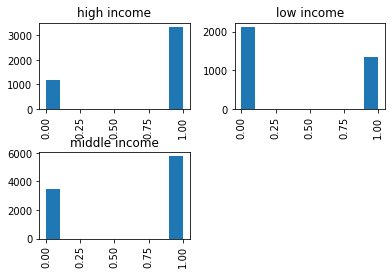

In [730]:
X_nonsf['onlineshop'].hist(by=X_nonsf['In_group'])

In [742]:
X_nonsf.groupby(['del_group', 'In_group']).size()

del_group     In_group     
1 to 5        high income      3486
              low income       3253
              middle income    8012
10 to 20      high income        84
              low income         12
              middle income      93
6 to 10       high income       463
              low income         73
              middle income     467
more than 20  high income       492
              low income        127
              middle income     680
dtype: int64

In [ ]:
# Frequency

In [544]:
nhts_per_CA_final=nhts_per_CA_final.query('DELIVER >0')

/Users/kjeong/anaconda3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DELIVER', ylabel='Density'>

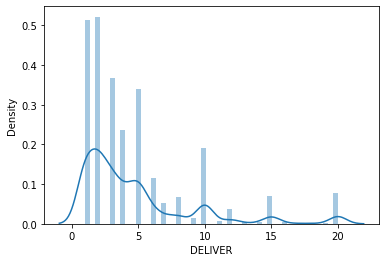

In [589]:
sns.distplot(nhts_per_CA_final.DELIVER)

In [588]:
nhts_per_CA_final.DELIVER.unique()

array([ 6,  1,  3,  4,  2, 15,  5,  8, 10, 12, 20,  7, 13, 17,  9, 11, 16,
       14, 18, 19])

In [657]:
#nhts_per_CA_final=nhts_per_CA_final.query('DELIVER <=20')

In [566]:
nhts_per_CA_final['DELIVER']=nhts_per_CA_final['DELIVER'].apply(lambda x: 20 if x >=20 else x)

In [576]:
x_var=['income_est', 'HHSIZE','R_SEX_IMP',
                     'EDUC_0',
                     'age_group_1', 'age_group_2',
                     'R_RACE_0',
                     'mode_group_0','mode_group_1',
                     'WEBUSE17_1']

In [586]:
nhts_per_nonSF=nhts_per_CA_final.query('HH_CBSA ==("31080","40140","40900","41740")')
nhts_per_SF=nhts_per_CA_final.query('HH_CBSA ==("41860","41940")')
X_nonsf=nhts_per_nonSF[x_var]
Y_nonsf=nhts_per_nonSF['DELIVER']
X_sf=nhts_per_SF[x_var]
Y_sf=nhts_per_SF['DELIVER']
trainX, testX, trainY, testY = train_test_split(X_sf, Y_sf, test_size = 0.7)
trainX=pd.concat([trainX,X_nonsf])
trainY=pd.concat([trainY,Y_nonsf])

In [549]:
trainY=np.log(trainY)

In [ ]:
result =sm.GLM(trainY,sm.add_constant(trainX),family=sm.families.NegativeBinomial(alpha=2)).fit()

In [557]:
result =sm.GLM(trainY,sm.add_constant(trainX),family=sm.families.NegativeBinomial(alpha=2)).fit()

filename = 'delivery_freq_model.sav'
joblib.dump(result, filename)

['delivery_freq_model.sav']

In [558]:
stats1=result.summary()
print(stats1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                DELIVER   No. Observations:                11483
Model:                            GLM   Df Residuals:                    11472
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32726.
Date:                Wed, 08 Dec 2021   Deviance:                       3354.7
Time:                        14:12:41   Pearson chi2:                 4.21e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8638      0.121      7.155   

In [559]:
filename= 'delivery_freq_model.sav'
loaded_model = joblib.load(filename)
input_x =sm.add_constant(testX)
pop_predict=loaded_model.predict(input_x)

/Users/kjeong/anaconda3/envs/python38/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [563]:
pop_predict = round(pop_predict,0)

In [564]:
pop_predict.value_counts()

4.0    856
5.0    741
6.0    501
7.0    135
3.0     67
8.0     62
2.0     25
9.0     10
dtype: int64

In [587]:
testY.value_counts()

2     468
1     415
3     325
5     309
4     204
10    169
6     130
15     88
20     83
8      75
7      53
12     32
9      16
11      9
13      6
14      5
16      3
18      3
19      2
17      2
Name: DELIVER, dtype: int64

In [491]:
trainY

20518    12
15920    15
8708     15
25004    15
16469    20
         ..
29189    15
29333    15
29334    20
29360    20
29455    20
Name: DELIVER, Length: 871, dtype: int64

In [492]:
trainY=np.log(trainY)

In [570]:
result =sm.OLS(trainY,sm.add_constant(trainX)).fit()

/Users/kjeong/anaconda3/envs/python38/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [571]:
stats1=result.summary()
print(stats1)

                            OLS Regression Results                            
Dep. Variable:                DELIVER   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     52.56
Date:                Wed, 08 Dec 2021   Prob (F-statistic):          4.28e-104
Time:                        15:08:15   Log-Likelihood:                -32744.
No. Observations:               11483   AIC:                         6.551e+04
Df Residuals:                   11472   BIC:                         6.559e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9823      0.333      5.956   

In [581]:
result =sm.GLM(trainY,sm.add_constant(trainX),family=sm.families.Poisson()).fit()

#filename = 'delivery_freq_model.sav'
# joblib.dump(result, filename)

In [582]:
pop_predict=result.predict(sm.add_constant(testX))

In [584]:
pop_predict = round(pop_predict,0)

In [585]:
pop_predict.value_counts()

5.0    848
4.0    782
6.0    458
7.0    121
3.0    112
8.0     49
2.0     26
9.0      1
dtype: int64

/Users/kjeong/anaconda3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DELIVER', ylabel='Density'>

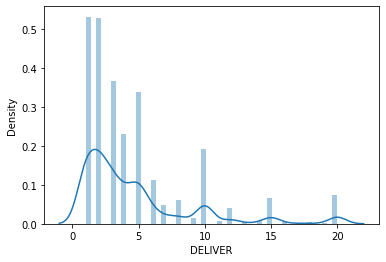

In [569]:
sns.distplot(trainY)

In [670]:
from sklearn.metrics import mean_squared_error

In [699]:
mean_squared_error(testY, pop_predict)

15.83495145631068

<AxesSubplot:xlabel='DELIVER'>

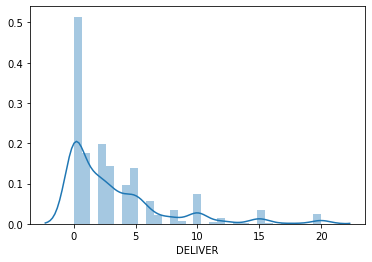

In [700]:
sns.distplot(testY)

<AxesSubplot:>

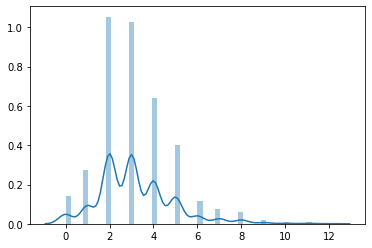

In [701]:
sns.distplot(pop_predict)

In [631]:
pop_predict=np.exp(pop_predict)